# import thư viện

In [75]:
import re
from tqdm import tqdm_notebook
import pandas as pd
import numpy as np
import tensorflow as tf
import keras  
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Processing Data


In [68]:
df = pd.read_csv("/content/drive/MyDrive/Miczone/HScode/training_hscode_data_bin_1.csv",dtype = {"name":"str",
                                                                                              "child_hscode":"str"})

In [69]:
df = df[["name","child_hscode"]]

In [70]:
df.rename(columns={"name":"text",
           "child_hscode":"label"},inplace =True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [71]:
label_map = (df.label.unique().astype("str"))

In [72]:
list_hscode_label = list(df.label.unique())
new_label = [x for x in range(0,len(list_hscode_label))]

In [73]:
data=df.text.to_list()
label = df.label.apply(lambda x: new_label[list_hscode_label.index(x)]).to_list()
label = np.asarray(label, dtype=np.int32)

In [74]:
df.label = label

In [76]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
new_data =[]
for sentence in data:
    text = sentence
    tokens = word_tokenize(text)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isdigit()==False]
    # filter out stop words
    words = [w for w in words if not w in stop_words]

    # stem
    new_data.append(" ".join(words))


In [77]:
new_data

['julan stainless steel nfc ring multifunctional nfc magic smart ring android windows mobile phone',
 'yanmis metal material nfc smart ring  smart ring  wearable device universal mobile phone  size11 ',
 'jxfs nfc smart ring intelligent rings  multifunctional magic wearable universal wear finger digital ring android windows mobile phone10 ',
 'ouyawei electronics nfc multifunctional waterproof intelligent ring smart digital ring gift black',
 'ouyawei electronics nfc multifunctional waterproof intelligent ring smart digital ring gift silver',
 'keydex nfc multifunction ring     fine ceramic  waterproof patent  tax excluded ',
 'ouyawei electronics nfc multifunctional waterproof intelligent ring smart digital ring gift silver',
 'ouyawei electronics nfc multifunctional waterproof intelligent ring smart digital ring gift silver',
 'smart ring  nfc phone smart accessories magic finger ring  suitable android ios windows  size  ',
 'kjglxd nfc smart ring male ring digital smart ring titaniu

# Build Glovec

In [13]:
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip

--2021-11-27 18:57:18--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2021-11-27 18:57:19--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2021-11-27 18:57:19--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip

In [14]:
!unzip glove.840B.300d.zip

Archive:  glove.840B.300d.zip
  inflating: glove.840B.300d.txt     


In [78]:
max = 0
for i in new_data:
  if len(i)>max:
    max = len(i)
max

262

In [79]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 262 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 300  # embedding dimensions for word vectors (word2vec/GloVe)

In [80]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [81]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(new_data)
sequences = tokenizer.texts_to_sequences(new_data)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 87798


In [82]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', df.label.shape)

Shape of data tensor: (96229, 262)
Shape of label tensor: (96229,)


# shuffle data and split train dev test

In [83]:
import numpy as np
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = df.label[indices]

In [84]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data, labels,
                                                stratify=labels, 
                                                test_size=0.2, random_state = 42,shuffle=True)

In [85]:
 X_val, X_test, y_val, y_test = train_test_split(X_val, y_val,
                                                stratify=y_val, 
                                                test_size=0.5, random_state = 42,shuffle=True)

In [86]:
X_train.shape

(76983, 262)

In [87]:
X_val.shape

(9623, 262)

In [88]:
X_test.shape

(9623, 262)

In [89]:
y_train.value_counts()

284    320
375    320
180    319
43     319
1      319
      ... 
73      82
57      81
376     80
42      80
355     80
Name: label, Length: 379, dtype: int64

In [92]:
y_val.value_counts()

375    40
43     40
234    40
180    40
162    40
       ..
168    10
355    10
42     10
376    10
66     10
Name: label, Length: 379, dtype: int64

# One hot label

In [93]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(y_train)

LabelBinarizer()

In [94]:
y_train = lb.transform(y_train)
y_val = lb.transform(y_val)

# Create embedding_matrix glovec

In [ ]:
embeddings_index = {}
f = open('/content/glove.840B.300d.txt')
print('Loading GloVe from:', '/content/glove.6B.100d.txt','...', end='')
for line in f:
    values = line.split()
    word = values[0]
    try:
      embeddings_index[word] = np.asarray(values[1:], dtype='float64')
    except ValueError:
      print(values[1:])
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

# build model LSTM

In [96]:
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [97]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer = Embedding(len(word_index) + 1,
                           300,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings',)
embedded_sequences = embedding_layer(sequence_input)
x = (embedded_sequences)
x = LSTM(256, return_sequences=True,name='lstm_layer')(embedded_sequences)
# x = LSTM(64, return_sequences=True)(x)
# x = LSTM(128, return_sequences=True)(x)
# x = LSTM(256, return_sequences=True)(x)
# x = Bidirectional(LSTM(256, return_sequences=True,name='lstm_layer'))(embedded_sequences)
# x = Bidirectional(LSTM(128, return_sequences=False))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
preds = Dense(379, activation="softmax")(x)

In [98]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/HScode/model/lstm_testquang.h5",
    monitor='val_loss',
    save_best_only=True)            

In [99]:
csv_logger = keras.callbacks.CSVLogger("/content/drive/MyDrive/HScode/model/lstm_testquang.csv",separator=',',append=True)        

In [100]:
model = Model(sequence_input, preds)
model.compile(loss = 'categorical_crossentropy',
             optimizer= tf.keras.optimizers.Adam(amsgrad=True),
             metrics = ['accuracy'])

In [101]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 262)]             0         
                                                                 
 embeddings (Embedding)      (None, 262, 300)          26339700  
                                                                 
 lstm_layer (LSTM)           (None, 262, 256)          570368    
                                                                 
 global_max_pooling1d_2 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 1024)              263168    
                                                           

In [102]:
print('Training progress:')
history = model.fit(X_train, y_train, epochs = 9, batch_size=32, validation_data=(X_val, y_val),verbose=1)

Training progress:
Epoch 1/9
2406/2406 [==============================] - 58s 24ms/step - loss: 2.3932 - accuracy: 0.4855 - val_loss: 1.0185 - val_accuracy: 0.7655
Epoch 2/9
2406/2406 [==============================] - 56s 23ms/step - loss: 1.1905 - accuracy: 0.7194 - val_loss: 0.8178 - val_accuracy: 0.8141
Epoch 3/9
2406/2406 [==============================] - 56s 23ms/step - loss: 0.9845 - accuracy: 0.7645 - val_loss: 0.7635 - val_accuracy: 0.8273
Epoch 4/9
2406/2406 [==============================] - 56s 23ms/step - loss: 0.8722 - accuracy: 0.7898 - val_loss: 0.7182 - val_accuracy: 0.8392
Epoch 5/9
2406/2406 [==============================] - 56s 23ms/step - loss: 0.7854 - accuracy: 0.8059 - val_loss: 0.6948 - val_accuracy: 0.8445
Epoch 6/9
2406/2406 [==============================] - 56s 23ms/step - loss: 0.7237 - accuracy: 0.8191 - val_loss: 0.6839 - val_accuracy: 0.8473
Epoch 7/9
2406/2406 [==============================] - 56s 23ms/step - loss: 0.6736 - accuracy: 0.8298 - val_lo

In [ ]:
#history = model.fit(X_train, y_train, epochs = 15, batch_size=32, validation_data=(X_val, y_val),verbose=1,callbacks=[model_checkpoint_callback,csv_logger])

# Evaluate model

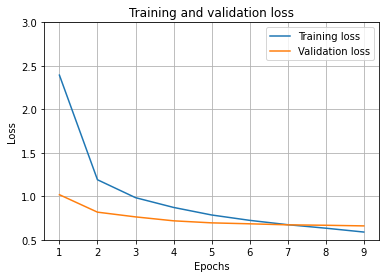

In [103]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.ylim(0.5,3)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show();

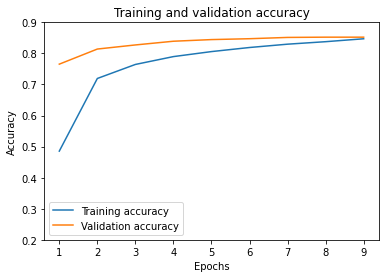

In [104]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylim(0.2,0.9)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/HScode/model/lstm_test2.h5")

In [105]:
pred = model.predict(X_test)

In [106]:
pred_idx = np.argmax(pred, axis=1) 

In [107]:
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [108]:
print(classification_report(y_test, pred_idx,target_names = list_hscode_label))

              precision    recall  f1-score   support

  71132090.0       0.94      0.88      0.91        34
  95030070.0       0.93      0.93      0.93        40
  36069090.0       0.90      0.82      0.86        11
  96139090.0       1.00      1.00      1.00        13
  36050000.0       0.92      0.92      0.92        13
  44029090.0       1.00      1.00      1.00        35
  83040091.0       0.94      0.97      0.96        34
  84401010.0       0.77      0.82      0.79        33
  48111099.0       1.00      0.83      0.91        12
  84659610.0       0.96      1.00      0.98        25
  85429000.0       0.82      0.54      0.65        26
  85371020.0       0.60      0.88      0.71        32
  48059320.0       1.00      0.97      0.98        30
  91021900.0       0.89      1.00      0.94        34
  71131990.0       0.58      1.00      0.73        11
  22029020.0       1.00      0.89      0.94        18
  38061000.0       0.94      0.97      0.96        35
  85198199.0       0.94    

In [109]:
y_test_1 = lb.transform(y_test)
model.evaluate(X_test, y_test_1)

301/301 [==============================] - 3s 9ms/step - loss: 0.6634 - accuracy: 0.8548


[0.6633532047271729, 0.8548269867897034]

# Create dictionary HScode + Accuracy

In [110]:
cm = confusion_matrix(y_test,pred_idx)

In [111]:
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [114]:
zip_iterator = zip(label_map, cmn.diagonal())

a_dictionary = dict(zip_iterator)

In [116]:
print(a_dictionary)

{'71132090.0': 0.8823529411764706, '95030070.0': 0.925, '36069090.0': 0.8181818181818182, '96139090.0': 1.0, '36050000.0': 0.9230769230769231, '44029090.0': 1.0, '83040091.0': 0.9705882352941176, '84401010.0': 0.8181818181818182, '48111099.0': 0.8333333333333334, '84659610.0': 1.0, '85429000.0': 0.5384615384615384, '85371020.0': 0.875, '48059320.0': 0.9666666666666667, '91021900.0': 1.0, '71131990.0': 1.0, '22029020.0': 0.8888888888888888, '38061000.0': 0.9714285714285714, '85198199.0': 0.7619047619047619, '84137099.0': 0.8076923076923077, '38140000.0': 0.9545454545454546, '28013000.0': 0.9230769230769231, '38089290.0': 0.9565217391304348, '34022019.0': 0.9047619047619048, '38220010.0': 1.0, '82013090.0': 0.9411764705882353, '84543000.0': 0.8846153846153846, '84649020.0': 0.5, '84411020.0': 0.8421052631578947, '96099030.0': 0.6923076923076923, '38099200.0': 0.4666666666666667, '90173000.0': 0.8928571428571429, '58101000.0': 0.5882352941176471, '84409010.0': 0.76, '48010090.0': 1.0, '37

In [117]:
import operator
sorted_d = dict( sorted(a_dictionary.items(), key=operator.itemgetter(1),reverse=True))
print('Dictionary in descending order by value : ',sorted_d)

Dictionary in descending order by value :  {'96139090.0': 1.0, '44029090.0': 1.0, '84659610.0': 1.0, '91021900.0': 1.0, '71131990.0': 1.0, '38220010.0': 1.0, '48010090.0': 1.0, '84709090.0': 1.0, '87088099.0': 1.0, '73181400.0': 1.0, '85112099.0': 1.0, '87088016.0': 1.0, '17031090.0': 1.0, '9072000.0': 1.0, '8026200.0': 1.0, '38099190.0': 1.0, '84828000.0': 1.0, '83024190.0': 1.0, '85176291.0': 1.0, '82074000.0': 1.0, '90118000.0': 1.0, '95089000.0': 1.0, '25059000.0': 1.0, '94048000.0': 1.0, '40159090.0': 1.0, '85045010.0': 1.0, '73249093.0': 1.0, '93040090.0': 1.0, '90151090.0': 1.0, '95064010.0': 1.0, '74199990.0': 1.0, '56089090.0': 1.0, '73218100.0': 1.0, '84748020.0': 1.0, '61178019.0': 1.0, '84672200.0': 1.0, '94056010.0': 1.0, '20087090.0': 1.0, '4059030.0': 1.0, '8022200.0': 1.0, '13022000.0': 1.0, '42050010.0': 1.0, '2075300.0': 1.0, '19012030.0': 1.0, '25120000.0': 1.0, '76109090.0': 1.0, '9109190.0': 1.0, '9052000.0': 1.0, '44013900.0': 1.0, '90138090.0': 1.0, '76072000.0':

# count number class accuracy < 0.5

In [122]:
count = 0
for x in sorted_d.keys():
  if sorted_d[x] < 0.5: 
    print(sorted_d[x])
    count = count + 1

0.48
0.4666666666666667
0.46153846153846156
0.45454545454545453
0.45454545454545453
0.4444444444444444
0.42857142857142855
0.42857142857142855
0.4117647058823529
0.40625
0.35714285714285715
0.35294117647058826
0.35294117647058826
0.34615384615384615
0.3333333333333333
0.3
0.2727272727272727
0.2631578947368421
0.18181818181818182
0.16666666666666666
0.07692307692307693


In [123]:
count

21